In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [3]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [4]:
IND_a= pd.read_csv("../Datasets/lac_2021_access.csv")
IND_u= pd.read_csv('../Datasets/lac_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [5]:
y.value_counts()

0    11702
1     2817
Name: fin34a, dtype: int64

In [6]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,5.0,1,1
1,1,1.0,2,4
2,1,1.0,2,5
3,2,6.0,1,4
4,2,6.0,2,2
...,...,...,...,...
14514,1,4.0,2,4
14515,1,1.0,2,3
14516,1,3.0,2,1
14517,2,2.0,3,4


In [7]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,1014,860,781,663,572
2,1171,1400,1572,1924,1897
3,162,180,288,628,1407


In [8]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [9]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,0.575963,0.223363,-0.137029,0.150685,-0.133693,0.086242,-0.706716,0.284349,0.649066
1,-0.540983,0.095745,-0.165277,0.237963,-0.168659,-0.484228,0.006560,-0.067309,-0.067420
2,-0.725239,0.031764,0.562952,0.007471,0.375722,1.274863,0.143882,-0.082502,-0.021850
3,1.089371,-0.051725,-0.020910,0.081066,-0.098069,0.073884,-0.652175,-0.066844,-0.063863
4,-0.555596,0.059556,-0.236784,-0.533768,-0.494880,0.545864,0.047210,-0.058376,-0.037016
...,...,...,...,...,...,...,...,...,...
14514,-0.718301,0.023695,0.217868,-0.084965,0.482072,-0.496800,-0.052568,-0.057310,-0.047769
14515,-0.540983,0.095745,-0.165277,0.237963,-0.168659,-0.484228,0.006560,-0.067309,-0.067420
14516,1.089371,-0.051725,-0.020910,0.081066,-0.098069,0.073884,-0.652175,-0.066844,-0.063863
14517,-0.718301,0.023695,0.217868,-0.084965,0.482072,-0.496800,-0.052568,-0.057310,-0.047769


In [10]:
mca_u = prince.MCA(n_components=24)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC15,uPC16,uPC17,uPC18,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24
0,-0.344868,0.040171,-0.631508,-0.436994,0.078448,-0.041468,0.375761,-0.089441,0.170067,0.079940,...,-0.043295,0.076475,-0.138295,0.146704,-0.196082,-0.244945,0.196352,-0.031013,-0.145857,-0.039189
1,0.251375,0.146417,-0.031385,0.359298,-0.231783,-0.001945,-0.066184,-0.080221,-0.059866,-0.064068,...,0.021117,0.017886,-0.001704,0.103716,-0.052148,0.256453,-0.033635,0.047066,-0.300888,-0.282977
2,0.861449,-0.213712,0.174198,-0.146824,0.234068,-0.065930,0.266830,0.052355,-0.238851,0.027187,...,-0.126179,0.442270,0.195262,0.322450,-0.533509,0.052833,-0.198142,0.256412,0.105642,0.043457
3,-0.723951,-0.368120,0.298689,0.025801,0.081779,-0.052806,-0.067746,-0.001477,-0.058844,-0.002683,...,0.021368,-0.044253,0.013553,-0.031537,-0.026640,0.003674,-0.027762,-0.010604,-0.011686,0.007956
4,0.405544,0.044336,0.038983,-0.096702,-0.195664,0.036510,-0.189281,0.077718,-0.103331,-0.009276,...,-0.003109,0.018926,0.006660,-0.264456,-0.143291,-0.129557,0.080511,-0.091204,0.457528,-0.056029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14514,0.650098,-0.360529,0.353434,0.015332,0.080300,-0.062749,0.106691,-0.163203,0.418215,0.042834,...,-0.150793,0.156464,0.180917,-0.118147,0.002491,-0.092490,0.089870,-0.249386,-0.111258,-0.061385
14515,0.134675,-0.096854,0.088586,-0.322873,0.321895,-0.015183,-0.045201,-0.064144,0.040141,-0.045966,...,-0.049299,0.094031,-0.071661,-0.224104,-0.153061,-0.259653,0.136408,-0.090083,-0.234910,-0.161599
14516,-0.723951,-0.368120,0.298689,0.025801,0.081779,-0.052806,-0.067746,-0.001477,-0.058844,-0.002683,...,0.021368,-0.044253,0.013553,-0.031537,-0.026640,0.003674,-0.027762,-0.010604,-0.011686,0.007956
14517,0.514398,-0.214862,0.414628,-0.116938,0.037123,-0.058641,0.106442,-0.180347,0.463015,0.040240,...,-0.069553,-0.003601,0.169020,-0.043610,-0.114468,0.271722,0.099103,-0.182815,-0.270876,-0.000660


In [11]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,female,age,educ,inc_q
0,0.575963,0.223363,-0.137029,0.150685,-0.133693,0.086242,-0.706716,0.284349,0.649066,-0.344868,...,-0.196082,-0.244945,0.196352,-0.031013,-0.145857,-0.039189,1,5.0,1,1
1,-0.540983,0.095745,-0.165277,0.237963,-0.168659,-0.484228,0.006560,-0.067309,-0.067420,0.251375,...,-0.052148,0.256453,-0.033635,0.047066,-0.300888,-0.282977,1,1.0,2,4
2,-0.725239,0.031764,0.562952,0.007471,0.375722,1.274863,0.143882,-0.082502,-0.021850,0.861449,...,-0.533509,0.052833,-0.198142,0.256412,0.105642,0.043457,1,1.0,2,5
3,1.089371,-0.051725,-0.020910,0.081066,-0.098069,0.073884,-0.652175,-0.066844,-0.063863,-0.723951,...,-0.026640,0.003674,-0.027762,-0.010604,-0.011686,0.007956,2,6.0,1,4
4,-0.555596,0.059556,-0.236784,-0.533768,-0.494880,0.545864,0.047210,-0.058376,-0.037016,0.405544,...,-0.143291,-0.129557,0.080511,-0.091204,0.457528,-0.056029,2,6.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14514,-0.718301,0.023695,0.217868,-0.084965,0.482072,-0.496800,-0.052568,-0.057310,-0.047769,0.650098,...,0.002491,-0.092490,0.089870,-0.249386,-0.111258,-0.061385,1,4.0,2,4
14515,-0.540983,0.095745,-0.165277,0.237963,-0.168659,-0.484228,0.006560,-0.067309,-0.067420,0.134675,...,-0.153061,-0.259653,0.136408,-0.090083,-0.234910,-0.161599,1,1.0,2,3
14516,1.089371,-0.051725,-0.020910,0.081066,-0.098069,0.073884,-0.652175,-0.066844,-0.063863,-0.723951,...,-0.026640,0.003674,-0.027762,-0.010604,-0.011686,0.007956,1,3.0,2,1
14517,-0.718301,0.023695,0.217868,-0.084965,0.482072,-0.496800,-0.052568,-0.057310,-0.047769,0.514398,...,-0.114468,0.271722,0.099103,-0.182815,-0.270876,-0.000660,2,2.0,3,4


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [13]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .52, 1:.77}], 
              'C': [100]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [14]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 100, 'class_weight': {0: 0.52, 1: 0.77}}
Best score: 0.8934891006278359


In [15]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9869903055409166
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2348
           1       0.83      0.97      0.90       556

    accuracy                           0.96      2904
   macro avg       0.91      0.96      0.93      2904
weighted avg       0.96      0.96      0.96      2904



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [16]:
acc= accuracy_score(y_test, y_pred)
pre= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f_1= f1_score(y_test, y_pred)
acc, rec, pre, f_1, auc1

(0.9573002754820936,
 0.9694244604316546,
 0.8343653250773994,
 0.8968386023294509,
 0.9869903055409166)

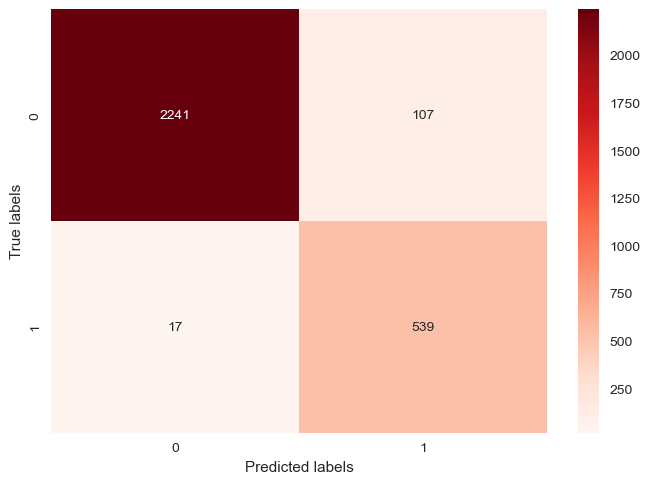

In [17]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [18]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

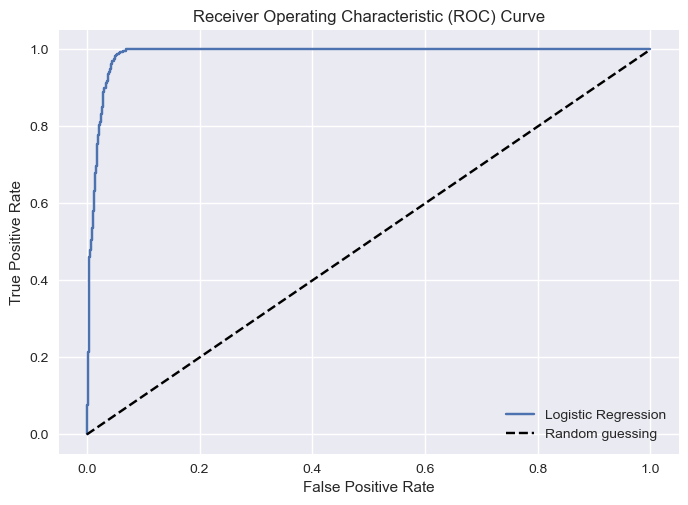

In [19]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [20]:
weights= [i for i in np.linspace(0, 1,100)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(434,435)],
    'max_depth': [i for i in range(13,14)],
    'min_samples_split': [i for i in range(20,21)],
    'min_samples_leaf': [i for i in range(2,3)],
    'max_features': ['sqrt'],
    'class_weight': [{0:.15 , 1: .58}]
}
rf = RandomForestClassifier(random_state= 42)

In [21]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.15, 1: 0.58}, 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 434}
Best score: 0.8697124537049703


In [22]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9836168543870186
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2348
           1       0.84      0.94      0.88       556

    accuracy                           0.95      2904
   macro avg       0.91      0.95      0.93      2904
weighted avg       0.96      0.95      0.95      2904



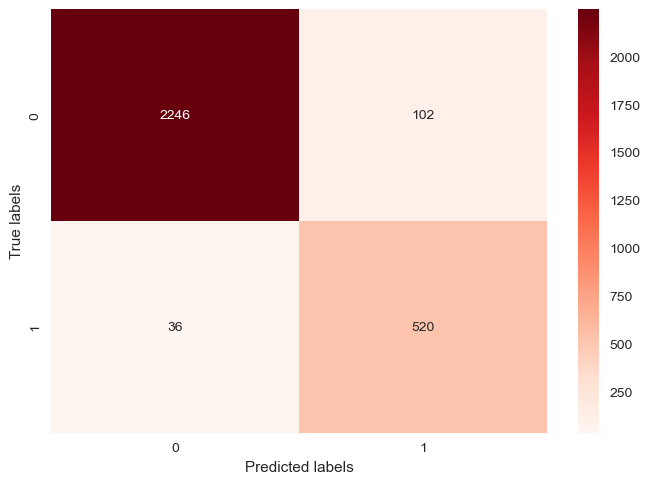

In [23]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

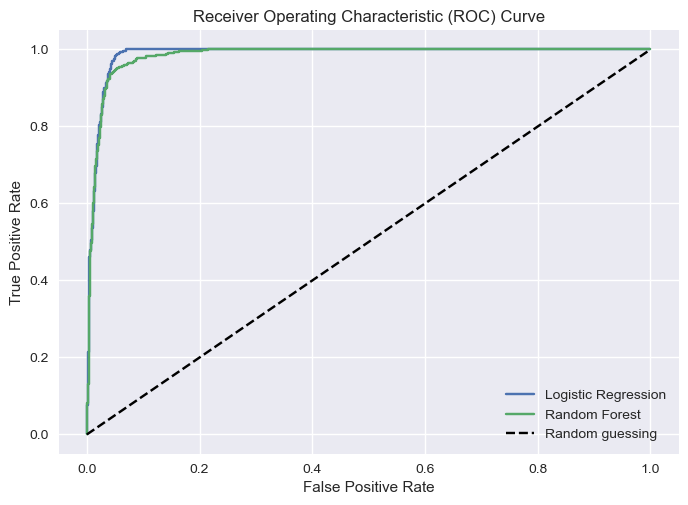

In [25]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [26]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [27]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.884403703598451


In [28]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [29]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.985538741068474
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2348
           1       0.86      0.89      0.88       556

    accuracy                           0.95      2904
   macro avg       0.92      0.93      0.92      2904
weighted avg       0.95      0.95      0.95      2904



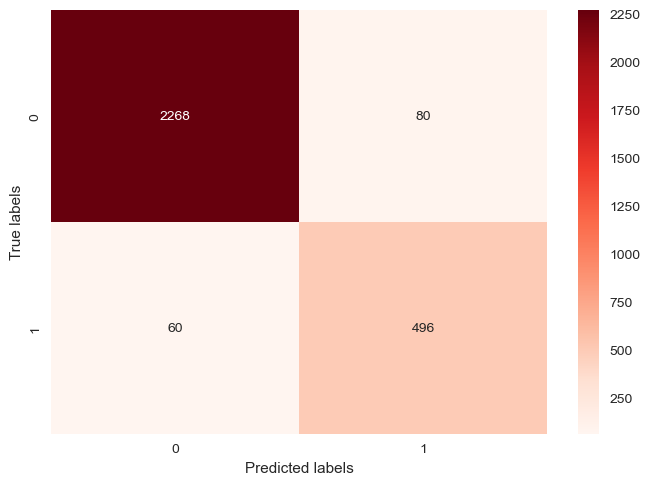

In [30]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [31]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

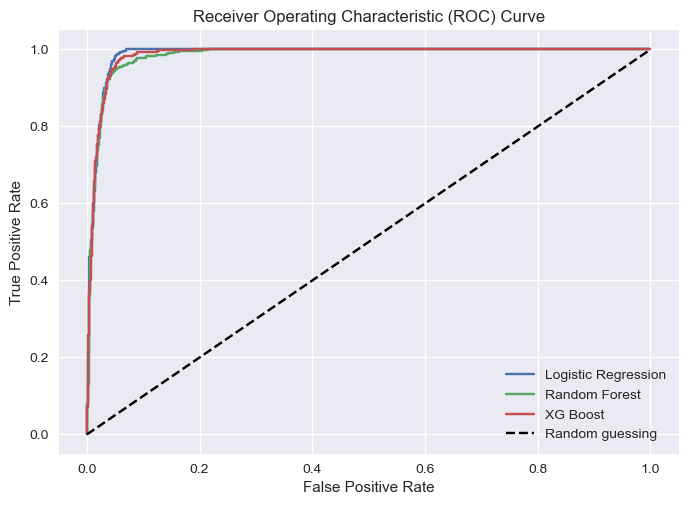

In [32]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [33]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [35]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
291/291 [==============================] - 0s 706us/step - loss: 0.2705 - precision: 0.8310 - recall: 0.5529 - val_loss: 0.1415 - val_precision: 0.7913 - val_recall: 0.9371
Epoch 2/50
291/291 [==============================] - 0s 461us/step - loss: 0.1256 - precision: 0.8400 - recall: 0.9230 - val_loss: 0.1202 - val_precision: 0.8024 - val_recall: 0.9277
Epoch 3/50
291/291 [==============================] - 0s 453us/step - loss: 0.1148 - precision: 0.8446 - recall: 0.9285 - val_loss: 0.1107 - val_precision: 0.8173 - val_recall: 0.9487
Epoch 4/50
291/291 [==============================] - 0s 452us/step - loss: 0.1091 - precision: 0.8495 - recall: 0.9307 - val_loss: 0.1075 - val_precision: 0.8277 - val_recall: 0.9184
Epoch 5/50
291/291 [==============================] - 0s 463us/step - loss: 0.1056 - precision: 0.8535 - recall: 0.9378 - val_loss: 0.1132 - val_precision: 0.8074 - val_recall: 0.9674
Epoch 6/50
291/291 [==============================] - 0s 472us/step - loss: 0.10

291/291 [==============================] - 0s 468us/step - loss: 0.0518 - precision: 0.9323 - recall: 0.9765 - val_loss: 0.1383 - val_precision: 0.8383 - val_recall: 0.9184
Epoch 46/50
291/291 [==============================] - 0s 460us/step - loss: 0.0512 - precision: 0.9316 - recall: 0.9743 - val_loss: 0.1392 - val_precision: 0.8368 - val_recall: 0.9324
Epoch 47/50
291/291 [==============================] - 0s 450us/step - loss: 0.0488 - precision: 0.9347 - recall: 0.9760 - val_loss: 0.1378 - val_precision: 0.8491 - val_recall: 0.9184
Epoch 48/50
291/291 [==============================] - 0s 474us/step - loss: 0.0493 - precision: 0.9387 - recall: 0.9787 - val_loss: 0.1409 - val_precision: 0.8549 - val_recall: 0.9068
Epoch 49/50
291/291 [==============================] - 0s 482us/step - loss: 0.0466 - precision: 0.9412 - recall: 0.9793 - val_loss: 0.1452 - val_precision: 0.8503 - val_recall: 0.9138
Epoch 50/50
291/291 [==============================] - 0s 456us/step - loss: 0.0449 - p

In [36]:
y_ = ann.predict(X_test)

91/91 [==============================] - 0s 244us/step


In [37]:
y_= y_.reshape(y_.shape[0],)

In [38]:
y_pred= np.array([round(i) for i in y_])

In [39]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.980966504479551
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2348
           1       0.83      0.92      0.87       556

    accuracy                           0.95      2904
   macro avg       0.91      0.94      0.92      2904
weighted avg       0.95      0.95      0.95      2904



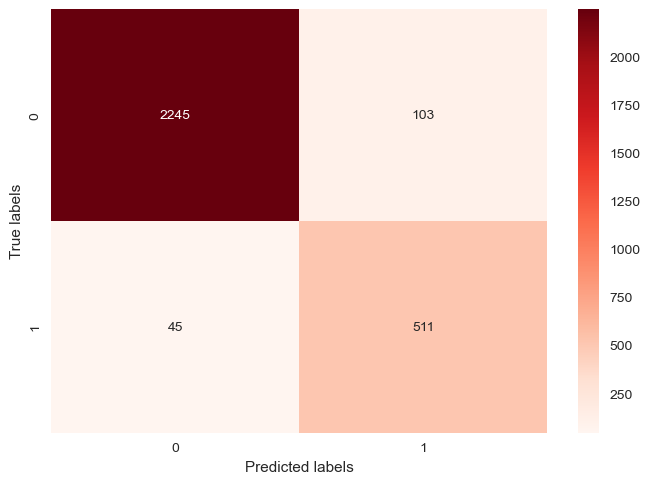

In [40]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [41]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

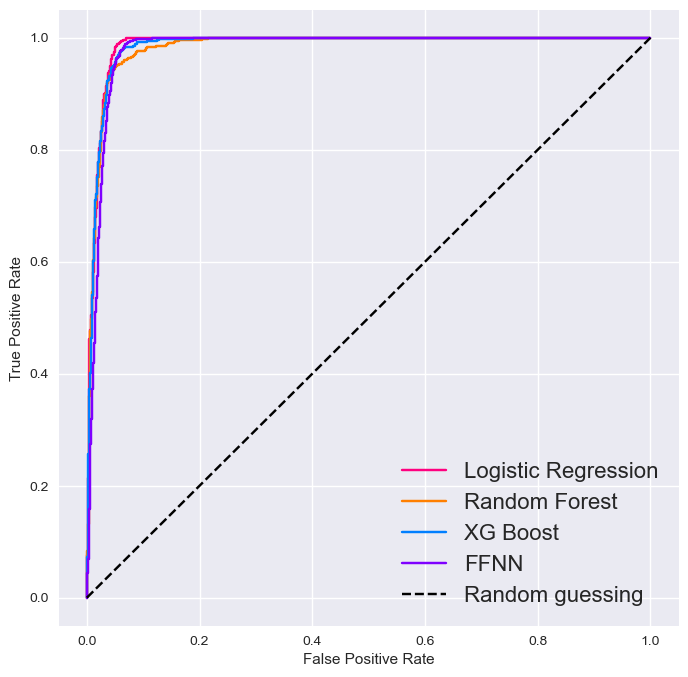

In [42]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_ken.png")
plt.show()

## Model Evaluations

In [43]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9573 & 0.9525 & 0.9518 & 0.9490 \\
   Recall & 0.9694 & 0.9353 & 0.8921 & 0.9191 \\
Precision & 0.8344 & 0.8360 & 0.8611 & 0.8322 \\
 F1-Score & 0.8968 & 0.8829 & 0.8763 & 0.8735 \\
      AUC & 0.9870 & 0.9836 & 0.9855 & 0.9810 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [44]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [45]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [46]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-2.468702113964037, 6.563693599328254, 0.12459318839200605)

In [47]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [48]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.2871104615732996)

In [49]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-1.6413455040038674, 2.335218249431227, -0.046674686016765075)

In [50]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [51]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [52]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [53]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

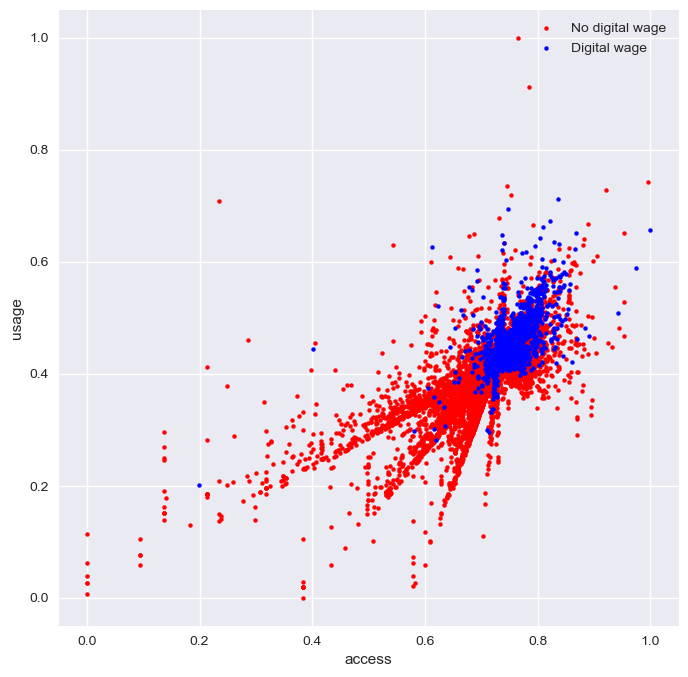

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_ken')
plt.show()

In [55]:
IND_fin['access'].describe()

count    14519.000000
mean         0.712890
std          0.066793
min          0.000000
25%          0.698078
50%          0.725190
75%          0.745066
max          1.000000
Name: access, dtype: float64

In [56]:
IND_fin['usage'].describe()

count    14519.000000
mean         0.401017
std          0.058705
min          0.000000
25%          0.375605
50%          0.407232
75%          0.431672
max          1.000000
Name: usage, dtype: float64

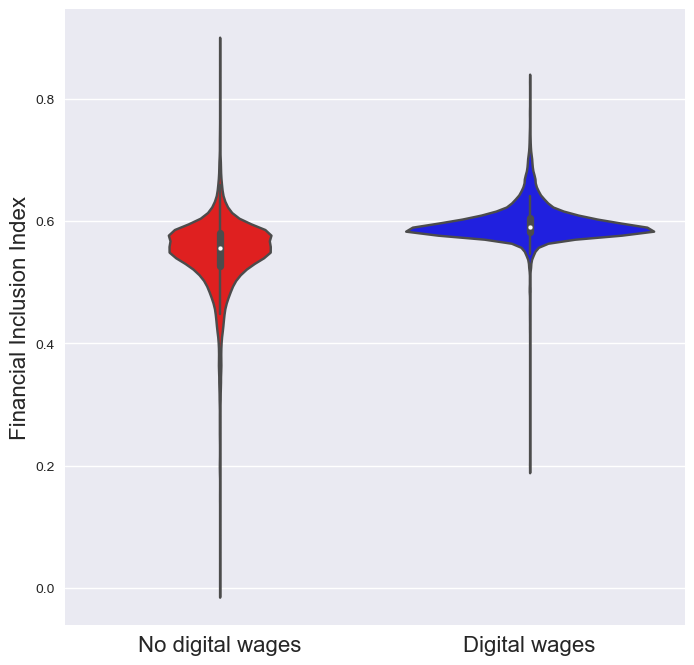

In [57]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_ken')

# Show the plot
plt.show()

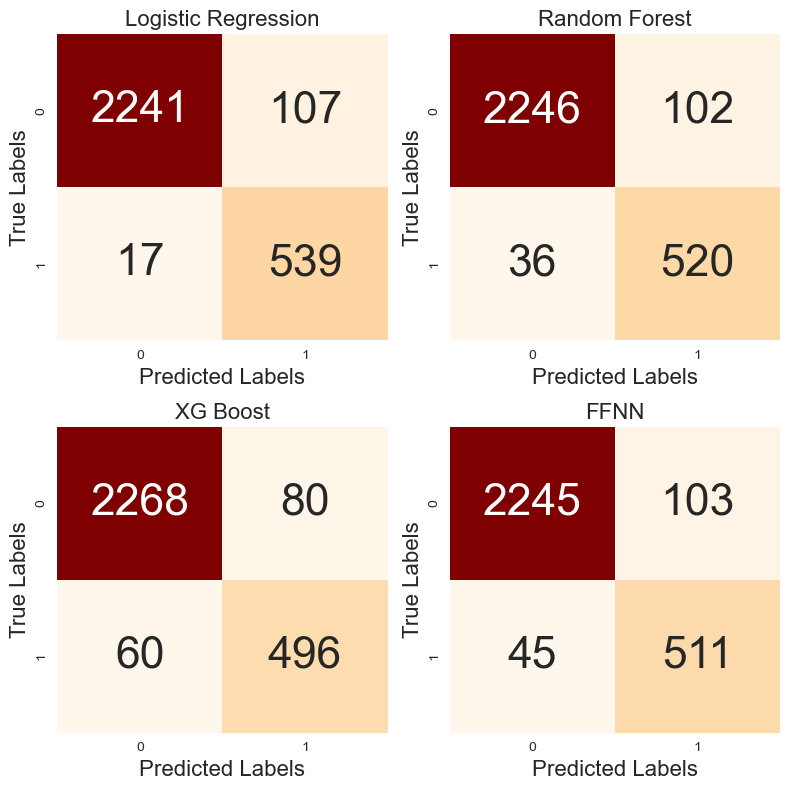

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="OrRd", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_lac.png')
# Display the plot
plt.show()

## Feature Importance

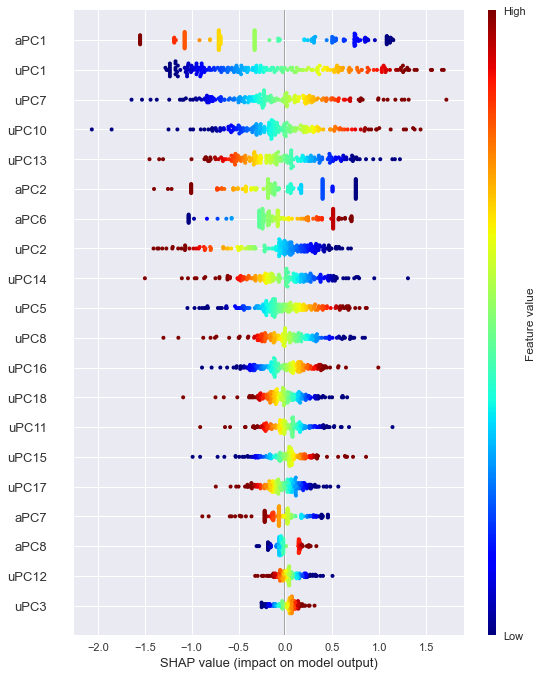

In [66]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [59]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

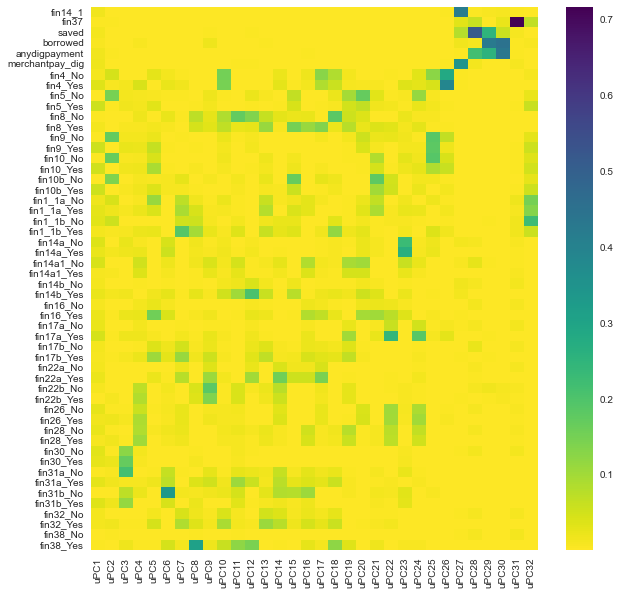

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_ken.png')
plt.show()

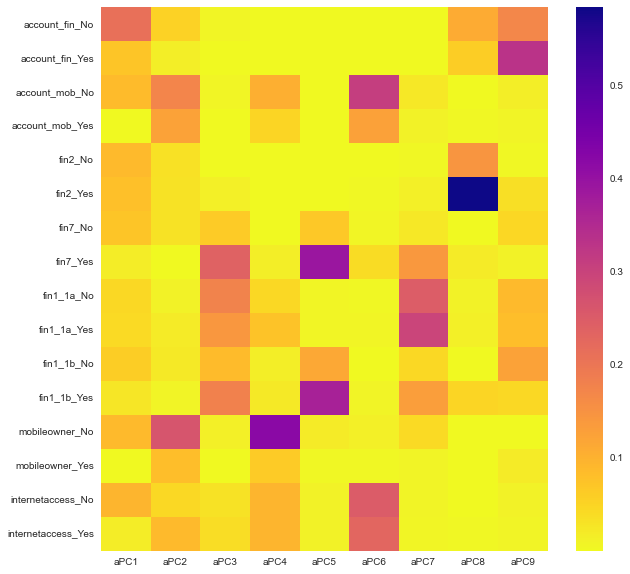

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_ken.png')
plt.show()

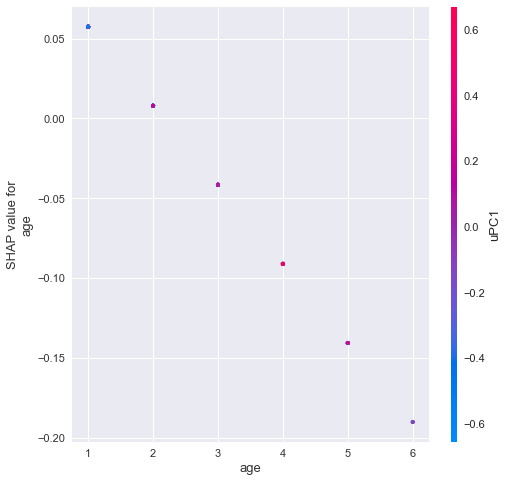

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

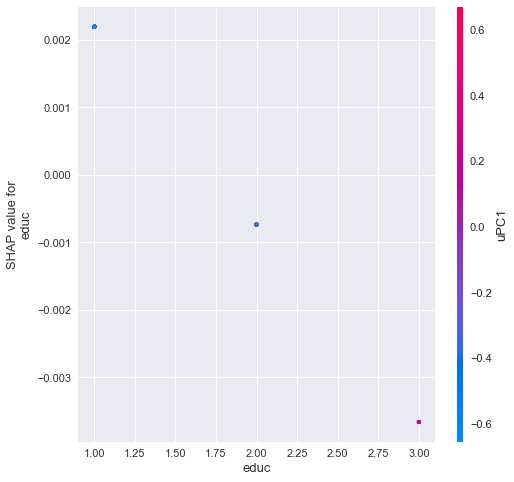

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

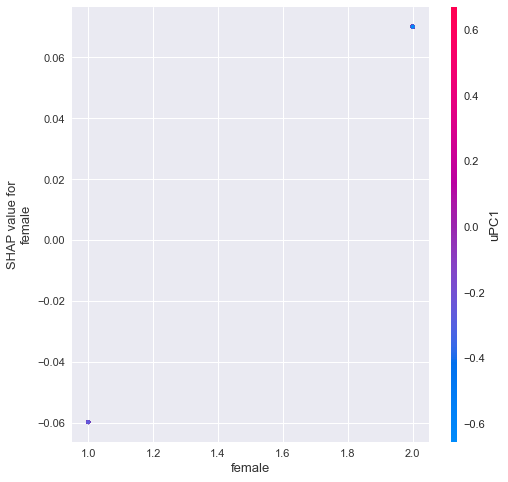

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

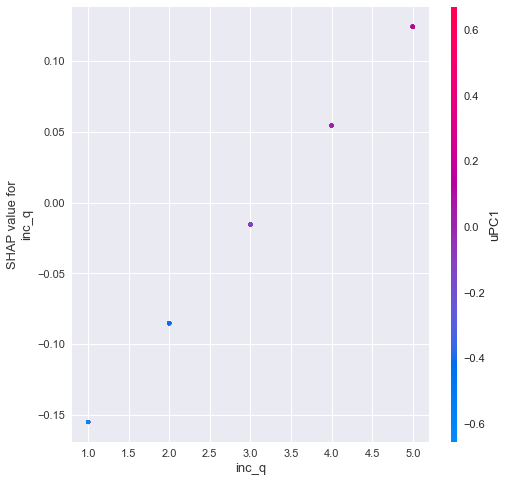

In [65]:
ig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()